<h1>Streaming Platfoms Stats</h1>
<h3>
DC-DSE Assignment 2024/25
<br>
Federica Tamerisco
</h3>

<h2>P1</h2>
For this project I decided to work on Netflix and Prime Video's datasets.

I used the ones available on [Kaggle](https://www.kaggle.com/), published by [OctopusTeam](https://www.kaggle.com/octopusteam).
<br>
They both share the same attributes, correlated to a certain media content:

- Title
- Type (movie or tv show)
- Genres
- Release Year
- IMDB ID
- IMDB Average Rating
- IMDB Number of Votes
- Available Countries (in which this content can be viewed)

Example for visualization purposes:

In [1]:
import pandas

csv = 'DATASET/netflix.csv'
df = pandas.read_csv(csv)
df.head(1)

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,518745.0,"AT, CH, DE"


I chose to run 5 queries:

- Top 20 highest rated titles on Netflix
- Top 10 most popular genres on Prime Video
- The number of titles released in 2001 on both platforms
- Most popular movie present on both platforms
- The tv show(s) that is (are) most distributed

For each one I used the same initialization:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import time as t

spark = SparkSession \
    .builder \
    .appName("Streaming Platforms Stats") \
    .getOrCreate()

<h2>P2</h2>
<h3>Query 1 - Top 20 highest rated titles on Netflix</h3>

In [ ]:
netflixPath = "hdfs:/user/user_dc_11/netflix.csv"

netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)

content = netflix.select("title", "imdbAverageRating")
top_titles = content.orderBy(col("imdbAverageRating").desc(), col("title").asc())
top_titles.show(20, truncate=False);

To compute this task I started from Netflix’ dataset.
<br>
First of all, I selected <tt>title</tt> and <tt>imdbAverageRating</tt>.
<br>
Then I ordered by ratings in descending order and titles in alphabetical order.
<br>
Finally, I displayed only the top 20.

<h3>Query 2 - Top 10 most popular genres on Prime Video</h3>

In [ ]:
primePath = "hdfs:/user/user_dc_11/prime.csv"

prime = spark.read.csv(primePath, header=True, inferSchema=True)

genres = prime.select("title", explode(split(col("genres"), ", ")).alias("genre"))
count = genres.groupBy("genre").count()
top_genres = count.orderBy(col("count").desc(), col("genre").asc())
top_genres.show(10, truncate=False)

I started from Prime’s dataset.
<br>
I selected <tt>title</tt>, while to work on the <tt>genres</tt> column I had to split the strings by using the $,$ as a separator.
<br>
With <tt>explode()</tt>, I took the array column and created a new row for each element in the array.
<br>
By adding <tt>.alias()</tt> I named the new column, making it accessible for subsequent operations.
<br>
Then I grouped by the new created differentiation and counted the total.
<br>
Finally, I ordered the counts in descending order, the genres in alphabetical order, and then showed the top 10.

<h3>Query 3 - The number of titles released in 2001 on both platforms</h3>

In [ ]:
netflixPath = "hdfs:/user/user_dc_11/netflix.csv"    
primePath = "hdfs:/user/user_dc_11/prime.csv"

netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)

netflix_2001 = netflix.select("title", "releaseYear").filter(col("releaseYear") == 2001)
prime_2001 = prime.select("title", "releaseYear").filter(col("releaseYear") == 2001)
titles = netflix_2001.union(prime_2001).distinct()
count = titles.count()
print(count)

I started from both datasets.
<br>
First of all, I selected <tt>title</tt> and <tt>releaseYear</tt> and filtered by the year $2001$.
<br>
To compare the two datasets I had to unite the two selections, removing the duplicates.
<br>
In the end, I counted the resulting titles.

<h3>Query 4 - Most popular movie present on both platforms</h3>

In [ ]:
netflixPath = "hdfs:/user/user_dc_11/netflix.csv"    
primePath = "hdfs:/user/user_dc_11/prime.csv"

netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)

join = netflix.join(prime, on=["title", "imdbAverageRating", "type"], how="inner")
movies = join.select("title", "imdbAverageRating").filter(col("type") == "movie")
most_popular = movies.orderBy(col("imdbAverageRating").desc(), col("title").asc()).limit(1)
most_popular.show(truncate=False)

I started from both datasets.
<br>
To compare them I proceeded with an inner join: this way I specifically looked for content that is present on both datasets, considering also the rating and the type.
<br>
I selected <tt>title</tt> and <tt>imdbAverageRating</tt> and then I filtered by <tt>type</tt>, to consider only the movies.
<br>
Finally, I ordered by <tt>imdbAverageRating</tt> in descending order, by <tt>title</tt> in alphabetical order, and then limited to only the first result.

<h3>Query 5 - The tv show(s) that is (are) most distributed</h3>

In [ ]:
netflixPath = "hdfs:/user/user_dc_11/netflix.csv"    
primePath = "hdfs:/user/user_dc_11/prime.csv"

netflix = spark.read.csv(netflixPath, header=True, inferSchema=True)
prime = spark.read.csv(primePath, header=True, inferSchema=True)

union = netflix.union(prime).distinct()
tv = union.select("title", "availableCountries", size(split(col("availableCountries"), ", ")).alias("count")).filter(col("type") == "tv")

most_distributed = tv.orderBy(col("count").desc(), col("title").asc()).limit(1)
most_distributed_with_truncate = most_distributed.withColumn("availableCountries", substring("availableCountries", 1, 20))

most_distributed_with_truncate.show(truncate=False)

I started from both datasets.
<br>
To compare the datasets I united them (leaving out the duplicates).
<br>
I selected <tt>title</tt> and <tt>availableCountries</tt> and filtered by <tt>type</tt> to consider only the tv shows.
<br>
I splitted the <tt>availableCountries</tt> and then counted the number of elements with <tt>size()</tt>.
<br>
I ordered by <tt>count</tt> in descending order, by <tt>title</tt> in alphabetical order and I limited to the first result.
<br>
For visualization purposes, I truncated the <tt>availableCountries</tt> column, as there are too many values inside: I limited to showing only the first 20 characters.

<h2>P3</h2>
To analyze the execution statistic, I run the tasks with different configurations:

* <tt>local[1]</tt>
* <tt>local[4]</tt>
* <tt>local[*]</tt>
* <tt>yarn</tt>

<div style="display: flex">
  <div style="display: inline-block; padding: 15px">
    <h3>Q1</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>8.540767431259155</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>8.37672758102417</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>8.14192247390747</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>8.917641401290894</td>
      </tr>
    </table>
  </div>

  <div style="display: inline-block; padding: 15px">
    <h3>Q2</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>12.267840385437012</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>10.944337606430054</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>10.791186332702637</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>11.07402491569519</td>
      </tr>
    </table>
  </div>

  <div style="display: inline-block; padding: 15px">
    <h3>Q3</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>13.950090169906616</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>11.783820152282715</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>11.380483627319336</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>12.656799793243408</td>
      </tr>
    </table>
  </div>
</div>

<div style="display: flex">
  <div style="display: inline-block; padding: 15px">
    <h3>Q4</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>10.836611032485962</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>10.876830339431763</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>10.711392879486084</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>10.825428485870361</td>
      </tr>
    </table>
  </div>

  <div style="display: inline-block; padding: 10px">
    <h3>Q5</h3>
    <table>
      <tr>
        <th>Mode</th>
        <th>Execution Time (s)</th>
      </tr>
      <tr>
        <td>local[1]</td>
        <td>15.221787691116333</td>
      </tr>
      <tr>
        <td>local[4]</td>
        <td>12.467206478118896</td>
      </tr>
      <tr>
        <td>local[*]</td>
        <td>12.58762264251709</td>
      </tr>
      <tr>
        <td>yarn</td>
        <td>12.314280986785889</td>
      </tr>
    </table>
  </div>
</div>

<h3>Summary</h3>
I calculated the average of the execution time with each mode:

Text(0, 0.5, 'Execution Time (s)')

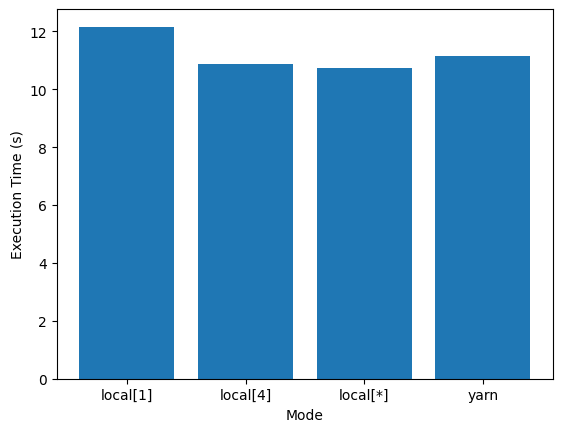

In [1]:
import matplotlib.pyplot as plt

modes = ['local[1]', 'local[4]', 'local[*]', 'yarn']

values = [
    12.163419742640614,
    10.88978443165792,
    10.722121791986523,
    11.157635716777548
]

plt.bar(modes, values);
plt.xlabel('Mode')
plt.ylabel('Execution Time (s)')

As we can see, the use of a single thread results in more time when executing locally the task, as there is no parallelization.
<br>
With more threads the time decreases.
<br>
Using a cluster setup doesn't significantly reduce execution time compared to using threads locally: this is typical scaling behavior for smaller tasks, where there's significant overhead caused by distributing the task across multiple nodes.
<br>
The local parallelization outperforms distributed execution.